In [2]:
import os
import json
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
import os
import shutil

# Define directories
base_dir = r"/content/sample_data/Classification Model"
xray_dir = os.path.join(base_dir, "xrays")
m1_dir = os.path.join(base_dir, "m1")
json_dir = os.path.join(base_dir, "jsonm1")

# Create new synchronized folders
sync_dir = os.path.join(base_dir, "synchronized_data")
os.makedirs(sync_dir, exist_ok=True)

# Folders for training data
sync_train_xray_dir = os.path.join(sync_dir, "train_xrays")
sync_train_m1_dir = os.path.join(sync_dir, "train_m1")
sync_train_json_dir = os.path.join(sync_dir, "train_jsonm1")

os.makedirs(sync_train_xray_dir, exist_ok=True)
os.makedirs(sync_train_m1_dir, exist_ok=True)
os.makedirs(sync_train_json_dir, exist_ok=True)

# Folders for unseen data
sync_unseen_m1_dir = os.path.join(sync_dir, "unseen_m1")
sync_unseen_json_dir = os.path.join(sync_dir, "unseen_jsonm1")

os.makedirs(sync_unseen_m1_dir, exist_ok=True)
os.makedirs(sync_unseen_json_dir, exist_ok=True)

# Get file names without extensions
xray_files = {os.path.splitext(f)[0] for f in os.listdir(xray_dir) if f.endswith(".png")}
m1_files = {os.path.splitext(f)[0] for f in os.listdir(m1_dir) if f.endswith(".png")}
json_files = {os.path.splitext(f)[0] for f in os.listdir(json_dir) if f.endswith(".json")}

# Find common patients for training data
common_patients = xray_files & m1_files & json_files

# Sync training data
for patient in common_patients:
    # Copy X-ray files
    xray_src = os.path.join(xray_dir, patient + ".png")
    xray_dest = os.path.join(sync_train_xray_dir, patient + ".png")
    shutil.copy(xray_src, xray_dest)

    # Copy M1 files
    m1_src = os.path.join(m1_dir, patient + ".png")
    m1_dest = os.path.join(sync_train_m1_dir, patient + ".png")
    shutil.copy(m1_src, m1_dest)

    # Copy JSON files
    json_src = os.path.join(json_dir, patient + ".json")
    json_dest = os.path.join(sync_train_json_dir, patient + ".json")
    shutil.copy(json_src, json_dest)

# Sync unseen data
for file in m1_files - common_patients:
    # Copy unseen M1 files
    unseen_m1_src = os.path.join(m1_dir, file + ".png")
    unseen_m1_dest = os.path.join(sync_unseen_m1_dir, file + ".png")
    shutil.copy(unseen_m1_src, unseen_m1_dest)

    # Copy corresponding JSON files for unseen data
    unseen_json_src = os.path.join(json_dir, file + ".json")
    unseen_json_dest = os.path.join(sync_unseen_json_dir, file + ".json")
    shutil.copy(unseen_json_src, unseen_json_dest)

print("Synchronized dataset created:")
print(f"Training data in {sync_train_xray_dir}, {sync_train_m1_dir}, {sync_train_json_dir}")
print(f"Unseen data in {sync_unseen_m1_dir}, {sync_unseen_json_dir}")


Synchronized dataset created:
Training data in /content/sample_data/Classification Model/synchronized_data/train_xrays, /content/sample_data/Classification Model/synchronized_data/train_m1, /content/sample_data/Classification Model/synchronized_data/train_jsonm1
Unseen data in /content/sample_data/Classification Model/synchronized_data/unseen_m1, /content/sample_data/Classification Model/synchronized_data/unseen_jsonm1


In [5]:
import os
import cv2
import numpy as np
import json

# Directories
sync_dir = r"/content/sample_data/Classification Model/synchronized_data"
train_m1_dir = os.path.join(sync_dir, "train")
train_json_dir = os.path.join(sync_dir, "train_json")
unseen_m1_dir = os.path.join(sync_dir, "unseen")
unseen_json_dir = os.path.join(sync_dir, "unseen_json")

# Label map
LABELS = {"distal": 0, "straight": 1, "mesial": 2}
IMG_SIZE = (224, 224)

# Preprocessing function
def preprocess_images_and_labels(m1_dir, json_dir):
    images = []
    labels = []

    for json_file in os.listdir(json_dir):
        if json_file.endswith(".json"):
            json_path = os.path.join(json_dir, json_file)

            # Read JSON file
            with open(json_path, "r") as f:
                data = json.load(f)

            for key in data:
                regions = data[key].get("regions", [])
                if not regions:
                    continue

                # Extract label
                tooth_label = None
                for region in regions:
                    if region["region_attributes"]["lines"] in LABELS:
                        tooth_label = region["region_attributes"]["lines"]

                # Skip if label is missing
                if not tooth_label or tooth_label not in LABELS:
                    continue

                # Load and resize corresponding image
                patient_id = os.path.splitext(json_file)[0]
                img_path = os.path.join(m1_dir, patient_id + ".png")
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    img_resized = cv2.resize(img, IMG_SIZE)
                    images.append(img_resized / 255.0)  # Normalize
                    labels.append(LABELS[tooth_label])

    images = np.expand_dims(np.array(images), axis=-1)  # Add channel dimension
    labels = np.array(labels)
    return images, labels

# Preprocess training and unseen data
X_train, y_train = preprocess_images_and_labels(train_m1_dir, train_json_dir)
X_unseen, y_unseen = preprocess_images_and_labels(unseen_m1_dir, unseen_json_dir)

print(f"Training data: {len(X_train)} images, {len(y_train)} labels")
print(f"Unseen data: {len(X_unseen)} images, {len(y_unseen)} labels")


Training data: 2800 images, 2800 labels
Unseen data: 99 images, 99 labels


In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)


Class weights: {0: 0.5064102564102564, 1: 1.0533333333333332, 2: 13.166666666666666}


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Convert labels to one-hot encoding
num_classes = len(LABELS)
y_train_categorical = to_categorical(y_train, num_classes=num_classes)

# Split training data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_categorical, test_size=0.2, random_state=42
)

# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



In [ ]:
# Train the model
history = model.fit(
    X_train_split, y_train_split,
    batch_size=16,
    epochs=250,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)

# Evaluate on validation data
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.2f}")


Epoch 1/250
1/4  12s 2s/step - accuracy: 0.4000 - loss: 1.0000 - val_accuracy: 0.6200 - val_loss: 0.8900
2/4  7s 2s/step - accuracy: 0.4000 - loss: 1.0000 - val_accuracy: 0.6200 - val_loss: 0.8900
3/4  10s 2s/step - accuracy: 0.4000 - loss: 1.0000 - val_accuracy: 0.6200 - val_loss: 0.8900
4/4  9s 2s/step - accuracy: 0.4000 - loss: 1.0000 - val_accuracy: 0.6200 - val_loss: 0.8900

Epoch 2/250
1/4  9s 2s/step - accuracy: 0.4023 - loss: 0.9961 - val_accuracy: 0.6214 - val_loss: 0.8865
2/4  10s 2s/step - accuracy: 0.4023 - loss: 0.9961 - val_accuracy: 0.6214 - val_loss: 0.8865
3/4  10s 2s/step - accuracy: 0.4023 - loss: 0.9961 - val_accuracy: 0.6214 - val_loss: 0.8865
4/4  11s 2s/step - accuracy: 0.4023 - loss: 0.9961 - val_accuracy: 0.6214 - val_loss: 0.8865

Epoch 3/250
1/4  10s 2s/step - accuracy: 0.4047 - loss: 0.9921 - val_accuracy: 0.6227 - val_loss: 0.8829
2/4  8s 2s/step - accuracy: 0.4047 - loss: 0.9921 - val_accuracy: 0.6227 - val_loss: 0.8829
3/4  8s 2s/step - accuracy: 0.4047 -

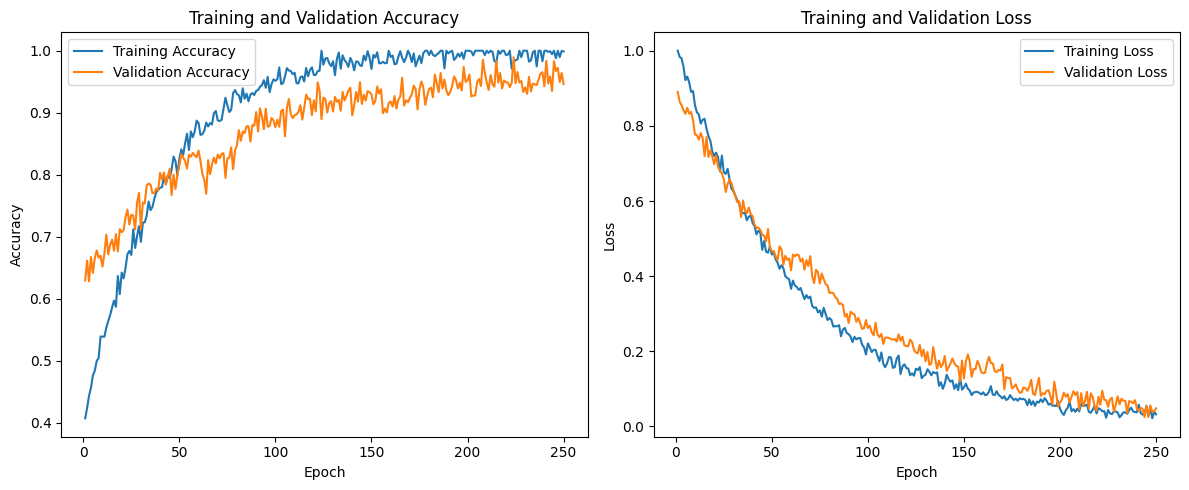

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Inverse mapping of LABELS to map integer values back to string labels
LABELS = {'distal': 0, 'straight': 1, 'mesial': 2}
LABELS_INV = {v: k for k, v in LABELS.items()}  # Inverse mapping: {0: 'distal', 1: 'straight', 2: 'mesial'}

# Predict on unseen data
y_pred_probs = model.predict(X_unseen)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_unseen, y_pred_classes, target_names=LABELS.keys()))

# Plot confusion matrix
cm = confusion_matrix(y_unseen, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot a test image with predicted and actual labels
def plot_test_image_with_labels(X_unseen, y_unseen, y_pred_classes, index=0):
    plt.figure(figsize=(6, 6))
    plt.imshow(X_unseen[index].squeeze(), cmap='gray')  # Assuming the image is grayscale

    # Use the inverse mapping to get the string labels
    predicted_label = LABELS_INV[y_pred_classes[index]]
    actual_label = LABELS_INV[y_unseen[index]]

    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}")
    plt.axis('off')
    plt.show()

# Example usage: Plot the first image in the unseen dataset
plot_test_image_with_labels(X_unseen, y_unseen, y_pred_classes, index=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Classification Report:
              precision    recall  f1-score   support

      distal       0.97      0.98      0.98        60
    straight       0.95      0.94      0.95        30
      mesial       0.90      0.85      0.87         9

    accuracy                           0.96        99
   macro avg       0.94      0.92      0.93        99
weighted avg       0.96      0.96      0.96        99

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

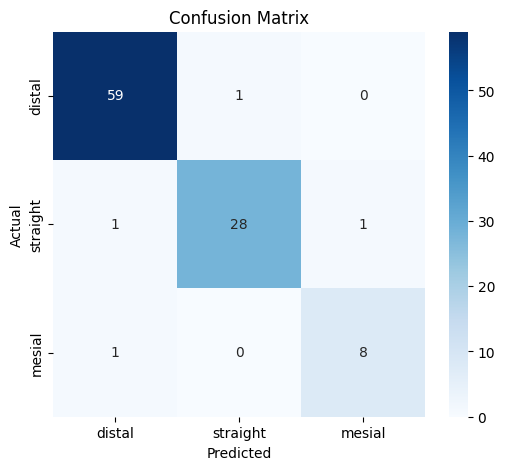

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Inverse mapping of LABELS to map integer values back to string labels
LABELS = {'distal': 0, 'straight': 1, 'mesial': 2}
LABELS_INV = {v: k for k, v in LABELS.items()}  # Inverse mapping: {0: 'distal', 1: 'straight', 2: 'mesial'}

# Predict on unseen data
y_pred_probs = model.predict(X_unseen)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_unseen, y_pred_classes, target_names=LABELS.keys()))

# Plot confusion matrix
cm = confusion_matrix(y_unseen, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot a test image with predicted and actual labels
def plot_test_image_with_labels(X_unseen, y_unseen, y_pred_classes, index=0):
    plt.figure(figsize=(6, 6))
    plt.imshow(X_unseen[index].squeeze(), cmap='gray')  # Assuming the image is grayscale

    # Use the inverse mapping to get the string labels
    predicted_label = LABELS_INV[y_pred_classes[index]]
    actual_label = LABELS_INV[y_unseen[index]]

    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}")
    plt.axis('off')
    plt.show()



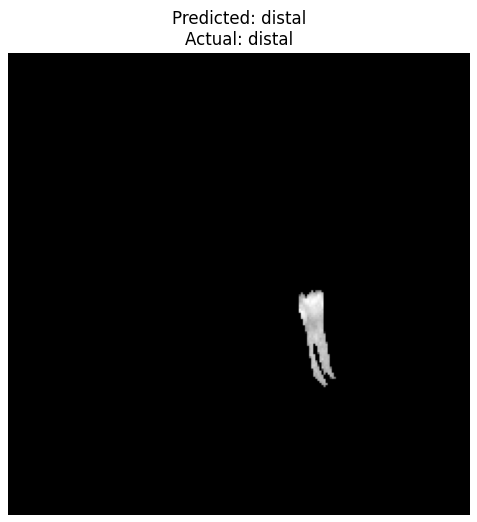

In [12]:
# Example usage: Plot the first image in the unseen dataset
plot_test_image_with_labels(X_unseen, y_unseen, y_pred_classes, index=0)

In [13]:
# Save the model in .keras format
model.save('my_model.h5')